## CNN을 이용하여 CIFAR10 분류기 만들기


1. CIFAR10 데이터를 불러와서 전처리를 수행합니다.

2. Convolutional Neural Network를 정의합니다.

3. Loss function을 정의합니다.

4. 학습을 수행합니다.

5. 테스트를 수행합니다.

### 1. Load and Normalize CIFAR10

In [ ]:
# CIFAR10 학습에 사용할 라이브러리를 불러옵니다.
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
# sklearn의 pipeline과 같은 용도로 사용됩니다.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] # channel-wise
)

# bs = 4   ## 나중에 GPU쓰면서 올려봅시다.
batch_size = 4  # mini-batch

# CIFAR10 불러옵니다.
# pytorch는 data 정의하고, dataloader를 정의합니다. train, test 둘 다 해줍니다.
train_data = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


# 나중에 출력을 위해 CIFAR10 클래스 정의.
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


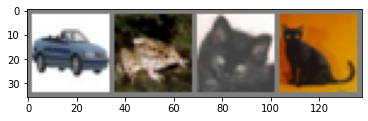

car	 frog	 cat	 cat	


In [ ]:
# 사용할 이미지를 batch_size 만큼 출력하는 코드.
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()  # batch size만큼의 이미지를 불러옵니다. e.g. 4

imshow(torchvision.utils.make_grid(images))
print(" ".join("%s\t" % classes[labels[j]] for j in range(batch_size)))

### 2. Define a CNN

In [ ]:
# def conv_change_size(kernel_size, stride, input_size):
#     return (input_size - kernel_size) / stride + 1

# def pool_change_size(input_size):
#     return int(input_size/2)

# Neural Network를 정의하기 위해서 Class를 구현해봅니다.
# nn.Module 기억하세요 !
import torch.nn as nn  # neural network를 구성하는 모든 components가 존재
import torch.nn.functional as F  # 모든 function. (특히, activation function)

class CNN(nn.Module):
    def __init__(self):
        ###########
        ### 5x5 ###
        ###########
        # super().__init__()  # nn.Module에 있는 __init__ 함수를 불러옵니다.
        # # conv1 -> (ReLU) -> maxpool -> conv2 -> (ReLU) -> maxpool -> FC -> FC -> FC
        # # in_channels는 input data의 channel수, out_channels는 filter개수
        # self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)  # 32x32x3 -> 28x28x6
        # self.pool1 = nn.MaxPool2d(2, 2)  # 28x28x6 -> 14x14x6
        # self.conv2 = nn.Conv2d(6, 16, 5) # 14x14x6 -> 10x10x16
        # self.pool2 = nn.MaxPool2d(2, 2)  # 10x10x16 -> 5x5x16
        # self.fc1 = nn.Linear(5*5*16, 120) # 5x5x16의 input
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)

        ###########
        ### 3x3 ###
        ###########
        super().__init__()  # nn.Module에 있는 __init__ 함수를 불러옵니다.
        conv1 -> (ReLU) -> maxpool -> conv2 -> (ReLU) -> maxpool -> FC -> FC -> FC
        in_channels는 input data의 channel수, out_channels는 filter개수
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)  # 32x32x3 -> 32x32x6
        self.pool1 = nn.MaxPool2d(2, 2)  # 32x32x6 -> 16x16x6
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1) # 16x16x6 -> 16x16x16
        self.pool2 = nn.MaxPool2d(2, 2)  # 16x16x16 -> 8x8x16
        self.fc1 = nn.Linear(8*8*16, 120) # 8x8x16의 input
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        ###########
        ### 7x7 ###
        ###########
        super().__init__()  # nn.Module에 있는 __init__ 함수를 불러옵니다.
        # conv1 -> (ReLU) -> maxpool -> conv2 -> (ReLU) -> maxpool -> FC -> FC -> FC
        # in_channels는 input data의 channel수, out_channels는 filter개수
        self.conv1 = nn.Conv2d(3, 6, 7, padding=3)  # 32x32x3 -> 32x32x6
        self.pool1 = nn.MaxPool2d(2, 2)  # 32x32x6 -> 16x16x6
        self.conv2 = nn.Conv2d(6, 16, 7) # 16x16x6 -> 10x10x16
        self.pool2 = nn.MaxPool2d(2, 2)  # 10x10x16 -> 5x5x16
        self.fc1 = nn.Linear(5*5*16, 120) # 5x5x16의 input
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        ##############
        ### cs231n ###
        ##############
        super().__init__()  # nn.Module에 있는 __init__ 함수를 불러옵니다.
        # conv1 -> (ReLU) -> maxpool -> conv2 -> (ReLU) -> maxpool -> FC -> FC -> FC
        # in_channels는 input data의 channel수, out_channels는 filter개수
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2)  # 32x32x3 -> 28x28x6
        self.conv2 = nn.Conv2d(6, 16, 5, padding=2) # 14x14x6 -> 10x10x16
        self.pool1 = nn.MaxPool2d(2, 2)  # 28x28x6 -> 14x14x6
        self.conv3 = nn.Conv2d(16, 24, 5, padding=2)
        self.conv4 = nn.Conv2d(24, 32, 5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)  # 10x10x16 -> 5x5x16
        self.conv5 = nn.Conv2d(32, 40, 5, padding=2)
        self.conv6 = nn.Conv2d(40, 48, 5, padding=2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4*4*48, 120) # 5x5x16의 input
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = self.pool3(F.relu(self.conv6(F.relu(self.conv5(x)))))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x

model = CNN()

### 3. Define a Loss function and optimizer

In [ ]:
# 학습을 위해 사용할 Loss Function과 Optimizer를 지정합니다.
import torch.optim as optim

learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss() # multi-class classification용
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

### 4. Train the Network

### 4-1. Training on CPU

In [ ]:
# 먼저 CPU로 학습을 시켜봅니다.
epochs = 5
iterations = 1000

# 구조를 외워두세요. pytorch로 구현할 때 사용하는 기본 뼈대입니다.
for epoch in range(epochs):
    train_loss = 0.0

    for i, data in enumerate(train_loader, 0):

        # 데이터를 불러옵니다.
        inputs, labels = data

        # gradient 초기화
        optimizer.zero_grad()

        # feed-forward
        outputs = model(inputs)  # forward 함수 call.
        loss = loss_fn(outputs, labels)  # cross-entropy loss 계산.

        # backprop
        loss.backward()  # local gradient 계산 및 loss backprop
        optimizer.step() # weight update

        # 특정 iteration마다 loss값 출력
        train_loss += loss.item()  # loss summation
        if i % 1000 == 999:
            print("[%d, %5d] loss: %.3f" % (epoch+1, i+1, train_loss/1000))
            train_loss = 0.0  # 특정 개수마다 loss를 출력해주기 때문에 초기화.

print("Finish Training")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  1000] loss: 2.304
[1,  2000] loss: 2.304
[1,  3000] loss: 2.303
[1,  4000] loss: 2.300
[1,  5000] loss: 2.298
[1,  6000] loss: 2.295
[1,  7000] loss: 2.289
[1,  8000] loss: 2.279
[1,  9000] loss: 2.257
[1, 10000] loss: 2.225
[1, 11000] loss: 2.204
[1, 12000] loss: 2.164
[2,  1000] loss: 2.121
[2,  2000] loss: 2.081
[2,  3000] loss: 2.026
[2,  4000] loss: 2.013
[2,  5000] loss: 1.979
[2,  6000] loss: 1.938
[2,  7000] loss: 1.913
[2,  8000] loss: 1.879
[2,  9000] loss: 1.871
[2, 10000] loss: 1.829
[2, 11000] loss: 1.784
[2, 12000] loss: 1.794
[3,  1000] loss: 1.777
[3,  2000] loss: 1.730
[3,  3000] loss: 1.691
[3,  4000] loss: 1.668
[3,  5000] loss: 1.697
[3,  6000] loss: 1.679
[3,  7000] loss: 1.686
[3,  8000] loss: 1.647
[3,  9000] loss: 1.663
[3, 10000] loss: 1.616
[3, 11000] loss: 1.606
[3, 12000] loss: 1.602
[4,  1000] loss: 1.594
[4,  2000] loss: 1.598
[4,  3000] loss: 1.556
[4,  4000] loss: 1.567
[4,  5000] loss: 1.557
[4,  6000] loss: 1.574
[4,  7000] loss: 1.520
[4,  8000] 

### 4-2. Training on GPU

In [ ]:
# 지금 사용가능한 GPU가 있는지 확인합니다. Google Colab에서는 런타임을 변경했는지 확인하는 용도이고, 로컬에서 세팅이 잘되었는지 확인도 가능합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# check GPU   # (K80) P100 T4, VRAM : 11/16/24
!nvidia-smi

Tue Sep 28 06:33:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    29W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# convert to CUDA tensors
model.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(24, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(32, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv6): Conv2d(40, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=768, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# 이번엔 GPU training입니다.
epochs = 5
iterations = 1000

# 구조를 외워두세요. pytorch로 구현할 때 사용하는 기본 뼈대입니다.
for epoch in range(epochs):
    train_loss = 0.0

    for i, data in enumerate(train_loader, 0):

        # 데이터를 불러옵니다.  # GPU로 보내줍니다. # torch.tensor.to()
        inputs, labels = data[0].to(device), data[1].to(device)

        # gradient 초기화
        optimizer.zero_grad()

        # feed-forward
        outputs = model(inputs)  # forward 함수 call.
        loss = loss_fn(outputs, labels)  # cross-entropy loss 계산.

        # backprop
        loss.backward()  # local gradient 계산 및 loss backprop
        optimizer.step() # weight update

        # 특정 iteration마다 loss값 출력
        train_loss += loss.item()  # loss summation
        if i % 2000 == 1999:
            print("[%d, %5d] loss: %.3f" % (epoch+1, i+1, train_loss/2000))
            train_loss = 0.0  # 특정 개수마다 loss를 출력해주기 때문에 초기화.

print("Finish Training with GPU")

[1,  2000] loss: 2.303
[1,  4000] loss: 2.303
[1,  6000] loss: 2.303
[1,  8000] loss: 2.303
[1, 10000] loss: 2.303
[1, 12000] loss: 2.303
[2,  2000] loss: 2.303
[2,  4000] loss: 2.303
[2,  6000] loss: 2.303
[2,  8000] loss: 2.303
[2, 10000] loss: 2.303
[2, 12000] loss: 2.303
[3,  2000] loss: 2.303
[3,  4000] loss: 2.303
[3,  6000] loss: 2.303
[3,  8000] loss: 2.303
[3, 10000] loss: 2.303
[3, 12000] loss: 2.303
[4,  2000] loss: 2.303
[4,  4000] loss: 2.302
[4,  6000] loss: 2.303
[4,  8000] loss: 2.302
[4, 10000] loss: 2.302
[4, 12000] loss: 2.303
[5,  2000] loss: 2.302
[5,  4000] loss: 2.302
[5,  6000] loss: 2.302
[5,  8000] loss: 2.302
[5, 10000] loss: 2.302
[5, 12000] loss: 2.301
Finish Training with GPU


In [ ]:
# save model
torch.save(model.state_dict(), "cifar10_model_cs231n.pth")

### 5. Test the CNN on test data

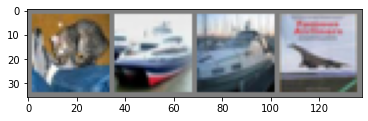

cat	 ship	 ship	 plane	


In [ ]:
dataiter = iter(test_loader) # iterator
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(" ".join("%s\t" % classes[labels[j]] for j in range(batch_size)))

In [ ]:
# test samples
outputs = model(images.to(device)) # GPU에 넣어줘야합니다.
outputs

tensor([[-0.2015, -1.4591,  1.1021,  2.4874, -0.0323,  0.8108,  1.8066, -2.4775,
         -0.1542, -2.1425],
        [ 5.5863,  4.5299, -0.7440, -2.4676, -1.8673, -5.5844, -4.6297, -5.4161,
          6.4342,  1.6980],
        [ 2.5596,  2.7065, -0.4586, -0.8823, -1.6057, -2.9917, -2.4336, -2.3437,
          3.1347,  1.5918],
        [ 4.2375, -0.3155,  0.6353, -0.7454, -1.1478, -3.3939, -1.2299, -3.6903,
          4.2244, -0.2108]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
# 출력값이 가장 큰 label 출력하기
_, pred = torch.max(outputs, 1) # 가장 큰 스코어를 가지는 index를 가져옵니다.
print("Predicted: ", " ".join("%5s" % classes[pred[j]] for j in range(batch_size)))

tensor([3, 8, 8, 0], device='cuda:0')

In [ ]:
labels.size(0)

4

In [ ]:
# test loss와 accuracy를 출력
# 이 코드도 test할 때 주로 사용되는 코드 형태임
correct = 0
total = 0

# pytorch에서는 Dynamic Computational Graph를 사용하기 때문에, inference할 때 gradient update를 하지 않는 조건을 꼭 지정해야한다!
with torch.no_grad(): # (*****)
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print("Accuracy : %.2f%%" % (correct / total * 100))

Accuracy : 12.47%


In [ ]:
# class별로 예측을 얼마나 하는지 확인
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for label, pred in zip(labels, preds):
            if label == pred:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * correct_count / total_pred[classname]
    print("Accuracy for class %s: %.2f%%, in total %d images" % (classname, accuracy, total_pred[classname]))

Accuracy for class plane: 0.00%, in total 1000 images
Accuracy for class car: 0.00%, in total 1000 images
Accuracy for class bird: 86.60%, in total 1000 images
Accuracy for class cat: 0.00%, in total 1000 images
Accuracy for class deer: 0.00%, in total 1000 images
Accuracy for class dog: 0.00%, in total 1000 images
Accuracy for class frog: 17.90%, in total 1000 images
Accuracy for class horse: 0.00%, in total 1000 images
Accuracy for class ship: 20.20%, in total 1000 images
Accuracy for class truck: 0.00%, in total 1000 images


Reference : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html